# Notebook to calculate and display seasonal flow statistics

This notebook reads a text-separated USGS RDB data file of daily average flow, then calculates discharge frequencies for each day of the year. Results are displayed in a plot and saved as a CSV file. 

@author = Anne Lightbody for ESCI 7/896.02  
@date = 2023-03-24  
@license = MIT -- https://opensource.org/licenses/MIT  

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

In [2]:
# Specify input parameters

# Name of the file to be analyzed; must be in working directory 
infile_name = "lamprey_daily.txt"  

# Name of the file where data will be saved; will be in working directory
outfile_name = "lamprey_freqs.csv" 

# Desired title for output figure
title = 'Lamprey River, NH'

# Frequency values to calculate and display 
freq_vec = [0.1, 0.25, 0.5, 0.75, 0.9]

In [3]:
# Load and wrangle USGS data

# Load raw USGS daily discharge data in units of cubic feet per second
data = pd.read_csv(infile_name,delimiter="\t",comment='#',
                      na_values=['Bkw','Fld', 'Ice', 'Mnt', 'Rat', 'Zfl'])

# Slice the resulting data frame to remove USGS format codes in first row
data = data.iloc[1:]     
          
# Convert datetime column to dates, then set as index
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M')
data.set_index(['datetime'], inplace = True)

# Identify which column contains discharge data using the USGS code for 
# discharge data, which is 00060. 
data = data.filter(like='00060',axis=1)  

# Two columns contain this code: the discharge data, and a second with text 
# flags about the discharge data. Keep the first column only (as a series)
data = data.iloc[:, 0]  

# Rename discharge data series
data.rename('discharge_cfs',inplace=True)

# Convert discharge data to numeric data 
data = pd.to_numeric(data) 

# Find first 10/1 and last 9/30 in record
startdate = data.loc[(data.index.month == 10) & (data.index.day == 1)].index[0]
enddate = data.loc[(data.index.month == 9) & (data.index.day == 30)].index[-1]

# Trim data to whole water years
data = data[startdate:enddate]   

# Display series of daily discharge
print(data)   

datetime
1934-10-01    207.00
1934-10-02    269.00
1934-10-03    271.00
1934-10-04    220.00
1934-10-05    177.00
               ...  
2020-09-26      5.65
2020-09-27      5.57
2020-09-28      5.49
2020-09-29      6.14
2020-09-30      8.21
Name: discharge_cfs, Length: 31412, dtype: float64


In [4]:
# Calculate statistics for each day of the year 
# for all years (combined) in historical record

maxdoy = 366  # Maximum number of days in a year

# Initialize empty data frame for results 
datacum = pd.DataFrame(np.full((maxdoy,len(freq_vec)),np.nan),
                     columns=freq_vec,index=np.arange(1,maxdoy+1))

#%% Find key frequency values 
for freq in freq_vec:
    datacum[freq] = data.groupby(data.index.dayofyear).quantile(freq)

In [5]:
# Create bonus rows containing NaN's in between each year
newdates = pd.date_range(startdate,enddate,freq = 'Y')+pd.Timedelta(1, unit='hour')
newvalues = pd.Series(np.full(len(newdates),np.nan),index=newdates)

# Add bonus rows to data series (to avoid plotting overlap) 
data = pd.concat([data,newvalues])
data.sort_index(inplace = True)

Text(0.5, 1.0, 'Lamprey River, NH')

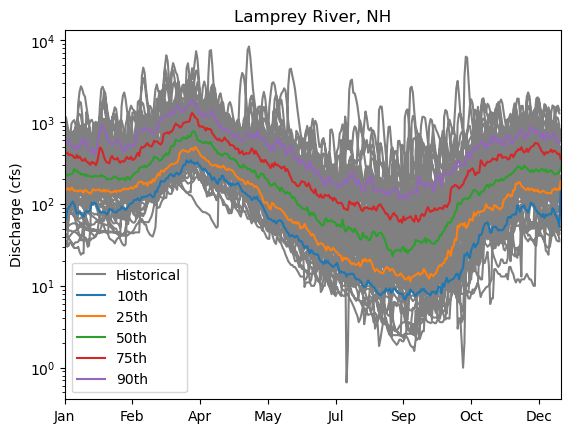

In [6]:
# Plot time series of seasonal discharge 
fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.plot(data.index.dayofyear,data,'-',
        color = 'gray',label = 'Historical')
for freq in freq_vec:
    ax.plot(datacum[freq],'-', label = f'{freq*100:.0f}th')
ax.set_ylabel('Discharge (cfs)')
ax.set_xlim(left = 0, right = 366)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.set_yscale('log')
ax.legend()
ax.set_title(title)

In [7]:
# Save results to file 
datacum.to_csv(outfile_name,sep=',')